#KOMMANA SRIRAM
#23BAI1156

#Setup, Imports, Dataset, Model

In [1]:
# What this cell does: Selects GPU (CUDA) if available, else CPU for model training.
# Output: Outputs the device being used (cuda or cpu).

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# What this cell does: Installs torchmetrics library required for evaluation metrics.
# Output: Displays pip installation logs.

!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.6 MB/s eta 0:00:00


In [3]:
# What this cell does: Imports all required libraries for deep learning, data processing, plotting, and metrics.
# Output: No output; libraries are loaded into the environment.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [4]:
# What this cell does: Generates a synthetic classification dataset, standardizes features, and splits into train/val/test sets.
# Output: No printed output; datasets are prepared.

X, y = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=10,
    n_redundant=10,
    n_classes=2,
    random_state=42
)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [5]:
# What this cell does: Defines the neural network architecture with one hidden layer and ReLU activation.
# Output: No output; model class is defined.

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# What this cell does: Creates PyTorch DataLoaders to load training, validation, and test data in batches.
# Output: No output; DataLoaders are created.

from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [8]:
# What this cell does: Defines CrossEntropyLoss as the loss function for classification.
# Output: No output; loss function initialized.

criterion = nn.CrossEntropyLoss()

#Regularizers (L1, L2, ElasticNet, Max-Norm) + Optimizers

In [9]:
# What this cell does: Defines L1 and L2 regularization functions to penalize model weights.
# Output: No output; functions defined.

def l1_regularization(model, lambda_l1):
    l1_norm = 0
    for param in model.parameters():
        l1_norm += torch.sum(torch.abs(param))
    return lambda_l1 * l1_norm


def l2_regularization(model, lambda_l2):
    l2_norm = 0
    for param in model.parameters():
        l2_norm += torch.sum(param ** 2)
    return lambda_l2 * l2_norm


def elastic_net_regularization(model, alpha, lambda_en):
    l1 = 0
    l2 = 0
    for param in model.parameters():
        l1 += torch.sum(torch.abs(param))
        l2 += torch.sum(param ** 2)
    return lambda_en * (alpha * l1 + (1 - alpha) * l2)

In [10]:
# What this cell does: Implements Max-Norm regularization to constrain weight magnitude.
# Output: No output; function defined.

def apply_max_norm(model, max_norm=3.0):
    for param in model.parameters():
        if param.requires_grad:
            norm = param.norm(2)
            if norm > max_norm:
                param.data = param.data * (max_norm / norm)

In [11]:
# What this cell does: Returns optimizer object based on selected optimization algorithm.
# Output: No output; optimizer selection function ready.

def get_optimizer(name, model, lr=0.01):
    if name == "GD":
        return optim.SGD(model.parameters(), lr=lr)

    elif name == "SGD":
        return optim.SGD(model.parameters(), lr=lr)

    elif name == "MB-SGD":
        return optim.SGD(model.parameters(), lr=lr)

    elif name == "Momentum":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    elif name == "Nesterov":
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

In [12]:
# What this cell does: Initializes evaluation metrics: Accuracy, Precision, Recall, and F1-score.
# Output: No output; metric objects created.

accuracy_metric = Accuracy(task="binary").to(device)
precision_metric = Precision(task="binary").to(device)
recall_metric = Recall(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

#Training Loop with Regularizers + Logging

In [13]:
# What this cell does: Computes sparsity by measuring fraction of near-zero weights.
# Output: No output; function defined.

def compute_sparsity(model, threshold=1e-3):
    total = 0
    near_zero = 0
    for param in model.parameters():
        total += param.numel()
        near_zero += torch.sum(torch.abs(param) < threshold).item()
    return near_zero / total

In [14]:
# What this cell does: Main training loop including forward pass, loss computation, regularization, backpropagation, validation, and sparsity tracking.
# Output: Prints epoch-wise training and validation losses.

def train_model(model, optimizer, regularizer_type, epochs=30,
                lambda_val=0.001, alpha=0.5, max_norm_val=3):

    train_losses = []
    val_losses = []
    sparsity_list = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for Xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)

            # Add regularization
            if regularizer_type == "L1":
                loss += l1_regularization(model, lambda_val)
            elif regularizer_type == "L2":
                loss += l2_regularization(model, lambda_val)
            elif regularizer_type == "ElasticNet":
                loss += elastic_net_regularization(model, alpha, lambda_val)

            loss.backward()
            optimizer.step()

            # Max Norm
            if regularizer_type == "MaxNorm":
                apply_max_norm(model, max_norm_val)

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                outputs = model(Xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        sparsity = compute_sparsity(model)
        sparsity_list.append(sparsity)

    return train_losses, val_losses, sparsity_list

#Running All Experiments

In [15]:
# What this cell does: Defines list of regularizers and optimizers for experimentation.
# Output: No output; experiment configuration stored.

regularizers = {
    "None": "None",
    "L1": "L1",
    "L2": "L2",
    "ElasticNet": "ElasticNet",
    "MaxNorm": "MaxNorm"
}

optimizers = ["GD", "SGD", "MB-SGD", "Momentum", "Nesterov"]

results = {}

In [16]:
# What this cell does: Runs training for every combination of regularizer and optimizer.
# Output: Displays training progress logs for each experiment.

for reg_name in regularizers:
    results[reg_name] = {}

    for opt_name in optimizers:
        print(f"Training: Regularizer={reg_name}, Optimizer={opt_name}")

        model = SimpleNN(input_dim=50).to(device)
        optimizer = get_optimizer(opt_name, model, lr=0.01)

        train_losses, val_losses, sparsity_list = train_model(
            model,
            optimizer,
            regularizer_type=reg_name,
            epochs=30
        )

        results[reg_name][opt_name] = {
            "train_loss": train_losses,
            "val_loss": val_losses,
            "sparsity": sparsity_list,
            "model": model
        }

Training: Regularizer=None, Optimizer=GD
Training: Regularizer=None, Optimizer=SGD
Training: Regularizer=None, Optimizer=MB-SGD
Training: Regularizer=None, Optimizer=Momentum
Training: Regularizer=None, Optimizer=Nesterov
Training: Regularizer=L1, Optimizer=GD
Training: Regularizer=L1, Optimizer=SGD
Training: Regularizer=L1, Optimizer=MB-SGD
Training: Regularizer=L1, Optimizer=Momentum
Training: Regularizer=L1, Optimizer=Nesterov
Training: Regularizer=L2, Optimizer=GD
Training: Regularizer=L2, Optimizer=SGD
Training: Regularizer=L2, Optimizer=MB-SGD
Training: Regularizer=L2, Optimizer=Momentum
Training: Regularizer=L2, Optimizer=Nesterov
Training: Regularizer=ElasticNet, Optimizer=GD
Training: Regularizer=ElasticNet, Optimizer=SGD
Training: Regularizer=ElasticNet, Optimizer=MB-SGD
Training: Regularizer=ElasticNet, Optimizer=Momentum
Training: Regularizer=ElasticNet, Optimizer=Nesterov
Training: Regularizer=MaxNorm, Optimizer=GD
Training: Regularizer=MaxNorm, Optimizer=SGD
Training: Reg

#Plotting Convergence Curves and Results

In [17]:
# What this cell does: Function to plot training loss curves for different optimizers.
# Output: Displays training loss vs epochs graph.

def plot_losses(results, reg_name):
    plt.figure(figsize=(12, 6))
    for opt_name in results[reg_name]:
        plt.plot(results[reg_name][opt_name]["train_loss"], label=opt_name)
    plt.title(f"Training Loss — {reg_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

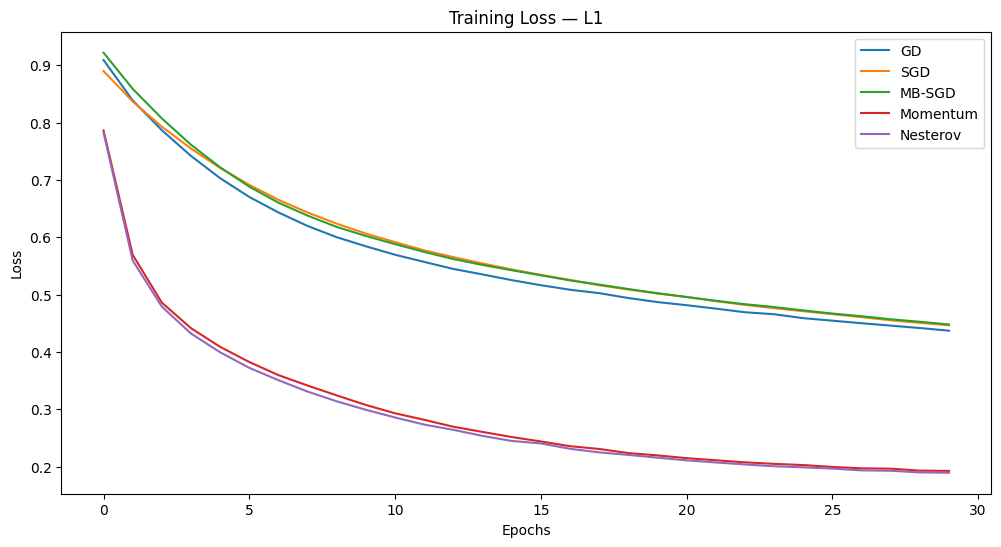

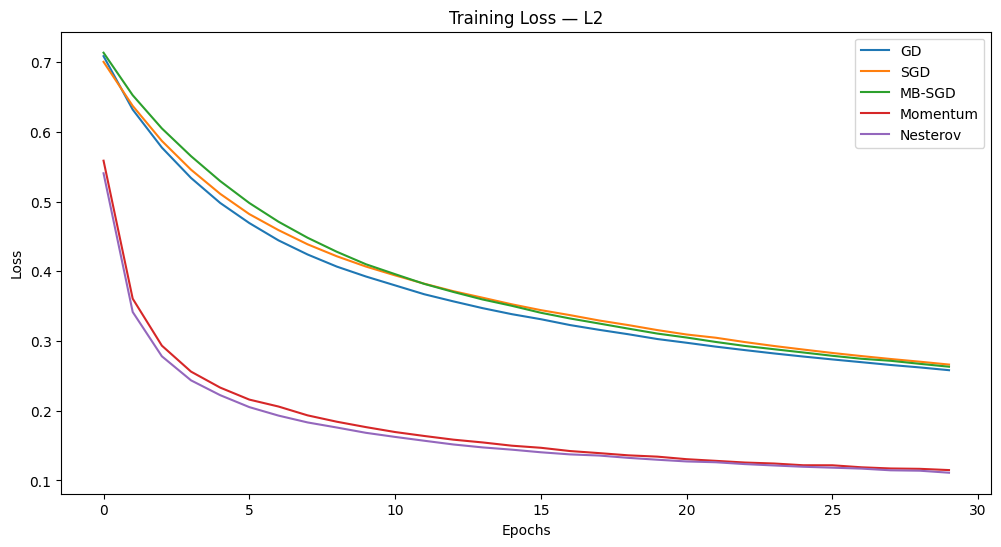

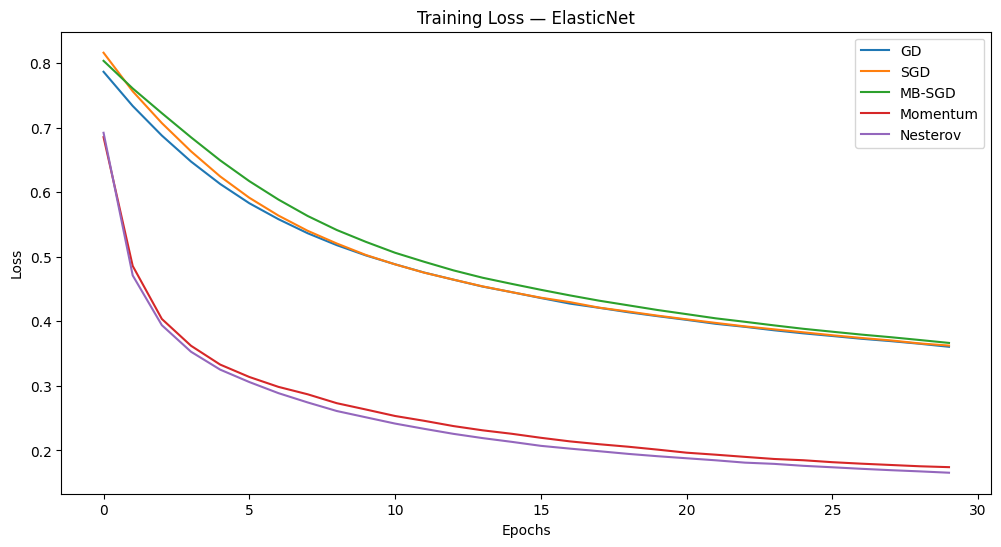

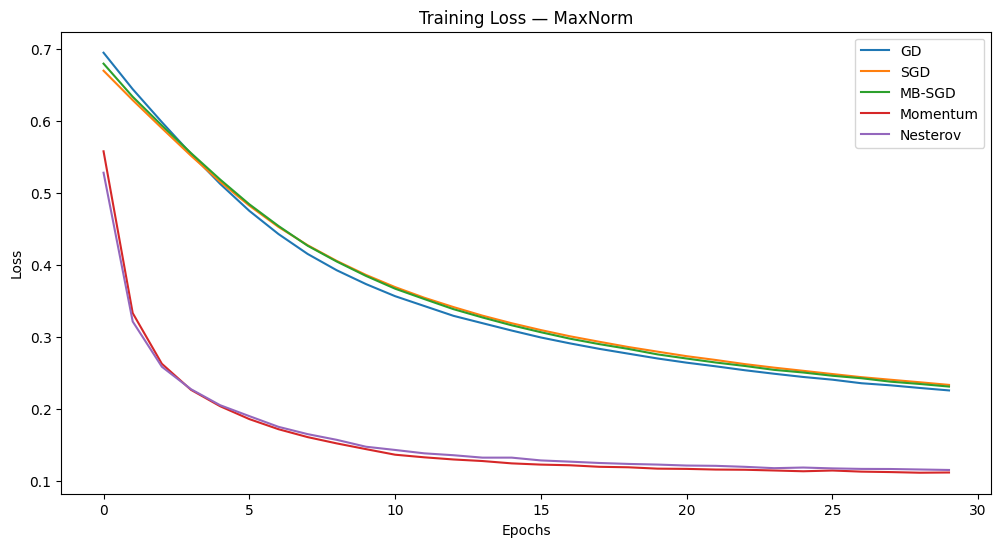

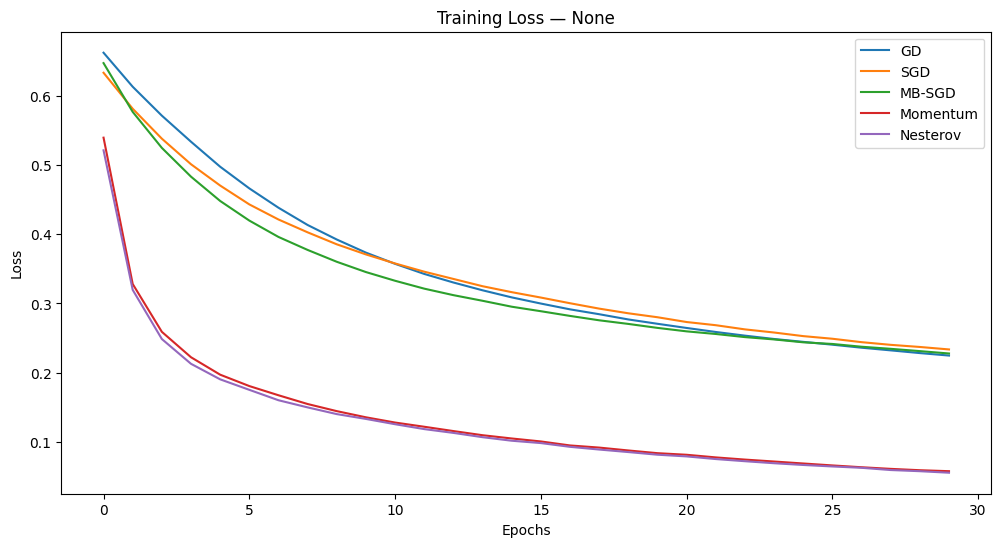

In [18]:
# What this cell does: Generates training loss plots for all regularizers.
# Output: Multiple training loss graphs displayed.

plot_losses(results, "L1")
plot_losses(results, "L2")
plot_losses(results, "ElasticNet")
plot_losses(results, "MaxNorm")
plot_losses(results, "None")

In [20]:
# What this cell does: Evaluates trained model on test data and computes performance metrics.
# Output: Returns accuracy, precision, recall, and F1 score.

def evaluate_model(model):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            _, predicted = torch.max(outputs, 1)
            preds.append(predicted)
            targets.append(yb)

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    acc = accuracy_metric(preds, targets).item()
    prec = precision_metric(preds, targets).item()
    rec = recall_metric(preds, targets).item()
    f1 = f1_metric(preds, targets).item()

    return acc, prec, rec, f1

In [21]:
# What this cell does: Collects final metrics and sparsity results from all experiments.
# Output: No output; results stored in list.

final_results = []

for reg in results:
    for opt in results[reg]:
        model = results[reg][opt]["model"]
        acc, prec, rec, f1 = evaluate_model(model)
        sparsity = results[reg][opt]["sparsity"][-1]

        final_results.append([reg, opt, acc, prec, rec, f1, sparsity])

In [22]:
# What this cell does: Creates a Pandas DataFrame summarizing experiment results.
# Output: Displays table of performance metrics.

import pandas as pd

df = pd.DataFrame(final_results, columns=[
    "Regularizer", "Optimizer", "Accuracy", "Precision", "Recall", "F1", "Sparsity"
])

df

,Regularizer,Optimizer,Accuracy,Precision,Recall,F1,Sparsity
0,None,GD,0.922667,0.935484,0.910995,0.923077,0.005303
1,None,SGD,0.908000,0.912929,0.905759,0.909330,0.006187
2,None,MB-SGD,0.910667,0.915567,0.908377,0.911958,0.006187
3,None,Momentum,0.949333,0.934343,0.968586,0.951157,0.003830
4,None,Nesterov,0.952000,0.945876,0.960733,0.953247,0.007661
5,L1,GD,0.917333,0.925532,0.910995,0.918206,0.107837
6,L1,SGD,0.912000,0.913613,0.913613,0.913613,0.097525
7,L1,MB-SGD,0.906667,0.914894,0.900524,0.907652,0.082204
8,L1,Momentum,0.964000,0.953964,0.976440,0.965071,0.605775
9,L1,Nesterov,0.965333,0.958763,0.973822,0.966234,0.636123


In [23]:
# What this cell does: Function to plot validation loss curves.
# Output: Displays validation loss graph.

def plot_val_losses(results, reg_name):
    plt.figure(figsize=(12, 6))
    for opt_name in results[reg_name]:
        plt.plot(results[reg_name][opt_name]["val_loss"], label=opt_name)
    plt.title(f"Validation Loss — {reg_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

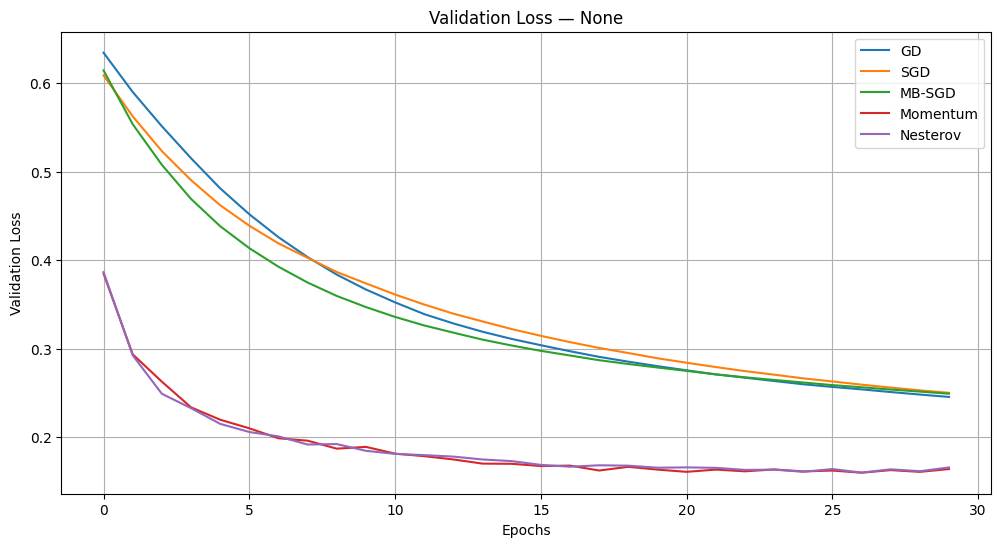

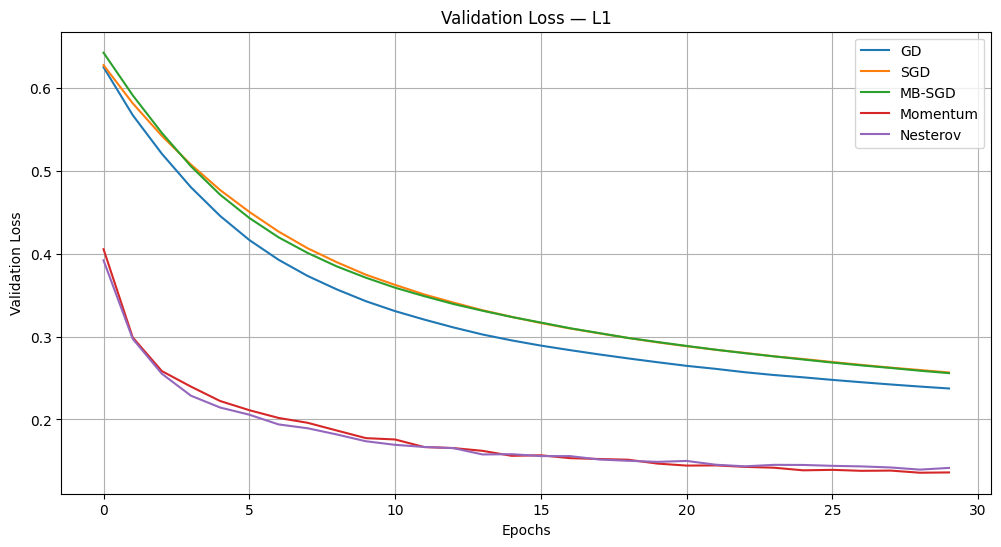

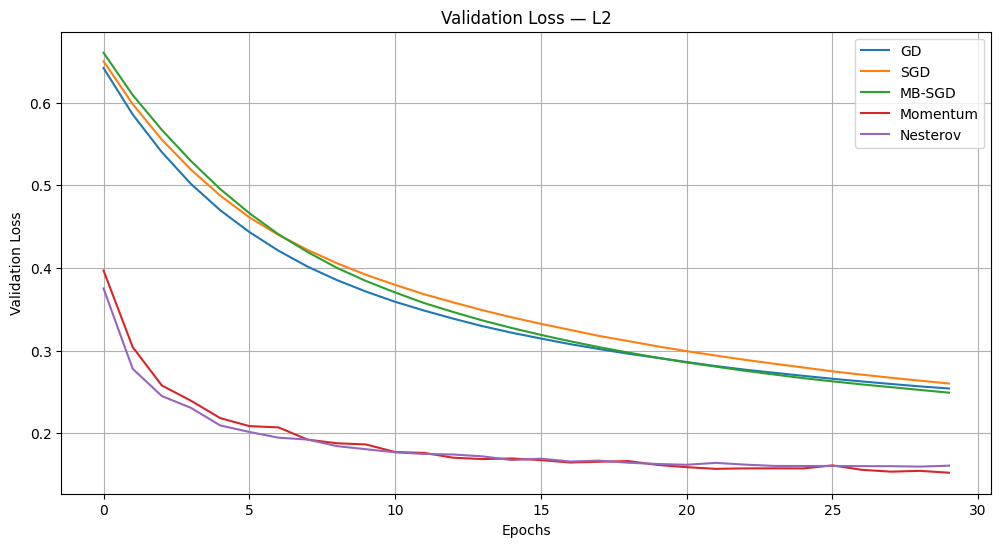

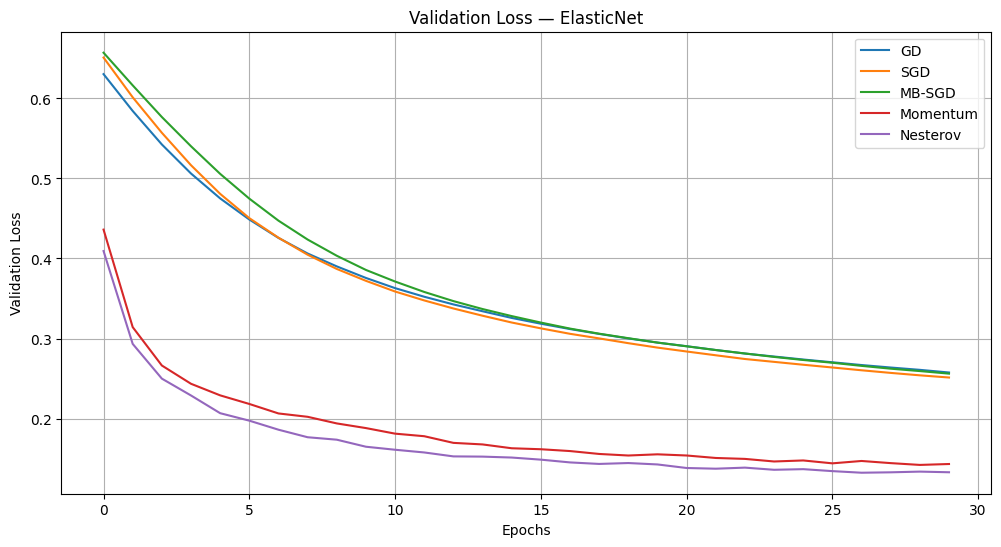

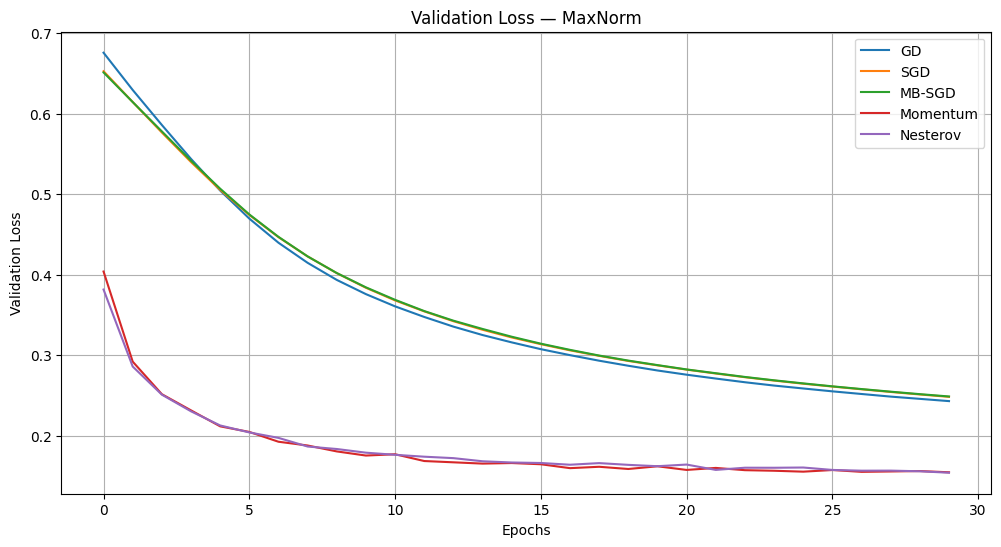

In [24]:
# What this cell does: Plots validation loss curves for all regularizers.
# Output: Multiple validation loss graphs displayed.

plot_val_losses(results, "None")
plot_val_losses(results, "L1")
plot_val_losses(results, "L2")
plot_val_losses(results, "ElasticNet")
plot_val_losses(results, "MaxNorm")

In [25]:
# What this cell does: Plots training vs validation loss to analyze overfitting or underfitting.
# Output: Displays comparison graph.

def plot_train_vs_val(results, reg_name, opt_name):
    plt.figure(figsize=(10, 5))
    plt.plot(results[reg_name][opt_name]["train_loss"], label="Train Loss")
    plt.plot(results[reg_name][opt_name]["val_loss"], label="Val Loss")
    plt.title(f"{reg_name} + {opt_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

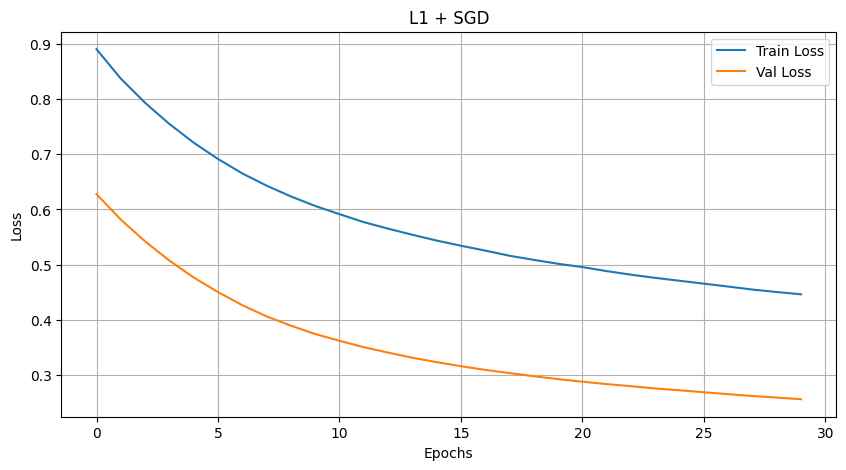

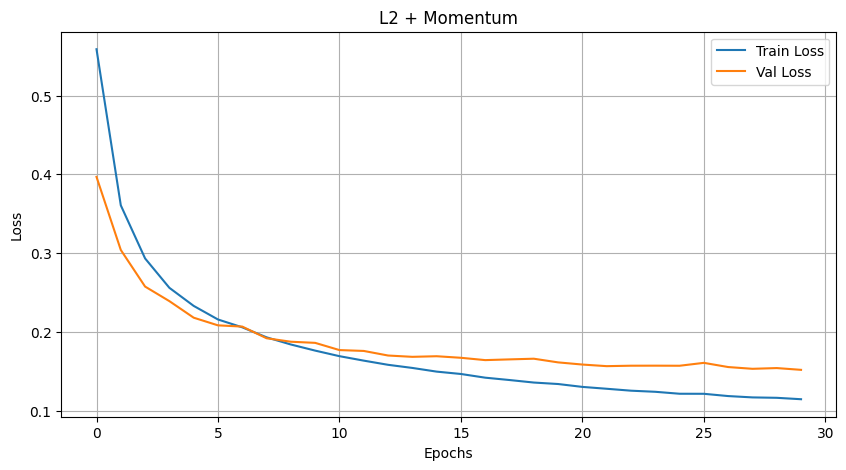

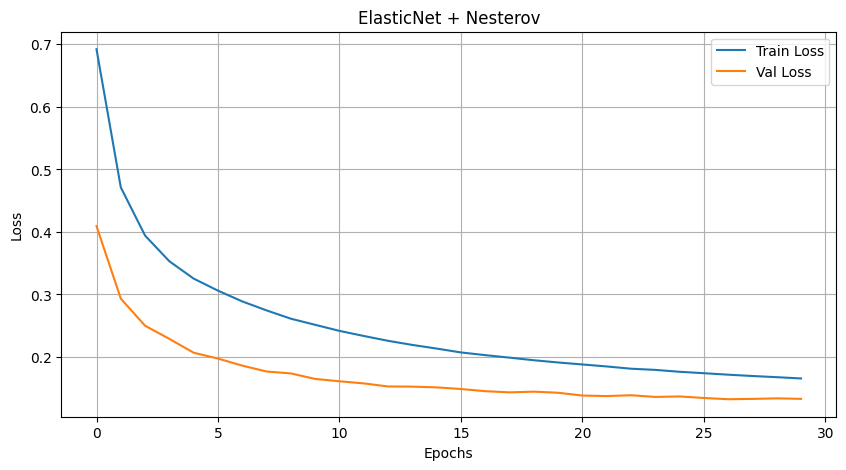

In [26]:
# What this cell does: Generates specific train-vs-validation comparisons for selected cases.
# Output: Displays comparison graphs.

plot_train_vs_val(results, "L1", "SGD")
plot_train_vs_val(results, "L2", "Momentum")
plot_train_vs_val(results, "ElasticNet", "Nesterov")